In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

In [3]:
df = pd.read_csv("weatherAUS_clean.csv")
print(df.shape)
df.head()

(123710, 31)


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,spring,summer,autumn,winterRain,springRain,summerRain,autumnRain,latitude,longitude,RainTomorrow
0,13.4,22.9,0.6,4.8,8.6,44.0,20.0,24.0,71.0,22.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0
1,7.4,25.1,0.0,4.8,8.6,44.0,4.0,22.0,44.0,25.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0
2,12.9,25.7,0.0,4.8,8.6,46.0,19.0,26.0,38.0,30.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0
3,9.2,28.0,0.0,4.8,8.6,24.0,11.0,9.0,45.0,16.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0
4,17.5,32.3,1.0,4.8,8.6,41.0,7.0,20.0,82.0,33.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0


In [4]:
df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Year', 'Month', 'Day', 'winter',
       'spring', 'summer', 'autumn', 'winterRain', 'springRain', 'summerRain',
       'autumnRain', 'latitude', 'longitude', 'RainTomorrow'],
      dtype='object')

In [5]:
target = "RainTomorrow"
features = ['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'Year',
 'Month',
 'Day',
 'winter',
 'spring',
 'summer',
 'autumn',
 'winterRain',
 'springRain',
 'summerRain',
 'autumnRain',
 'latitude',
 'longitude']

In [6]:
# Wczytanie potrzebnych bibliotek
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import neighbors
from sklearn.metrics import roc_auc_score

# Przygotujmy wrapper
def CVTestKNN(nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = neighbors.KNeighborsClassifier(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score(df[target].iloc[train].astype(int), predsTrain)
        testScore = roc_auc_score(df[target].iloc[test].astype(int), preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [56]:
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=100, n_jobs=-1, p=1, debug=True)
print(np.mean(testResults))

KNeighborsClassifier(n_jobs=-1, n_neighbors=100, p=1)
Train AUC: 0.8941582182693064 Valid AUC: 0.8843886121492149
KNeighborsClassifier(n_jobs=-1, n_neighbors=100, p=1)
Train AUC: 0.8941846907108395 Valid AUC: 0.8850760402710736
KNeighborsClassifier(n_jobs=-1, n_neighbors=100, p=1)
Train AUC: 0.8932817342427848 Valid AUC: 0.8882720801761281
KNeighborsClassifier(n_jobs=-1, n_neighbors=100, p=1)
Train AUC: 0.8944593795535115 Valid AUC: 0.882806416657825
KNeighborsClassifier(n_jobs=-1, n_neighbors=100, p=1)
Train AUC: 0.8935265312206809 Valid AUC: 0.8877334216531624
0.8856553141814809


In [57]:
import random
results=[]
paramList = []
for x in range(20):
    params = {"neighbors": random.randint(3, 200), 
              "p": random.randint(1, 2)
             }
    
    trainResults, testResults, predictions, indices = CVTestKNN(
        n_neighbors=params['neighbors'],
        p = params['p'])
    
    print(np.mean(testResults), params)
    results.append(np.mean(testResults))
    paramList.append(params)

0.8853970127672988 (28, 1)
0.8862968686803615 (73, 1)
0.8759537605914638 (122, 2)
0.8765763979726371 (42, 2)
0.8769963910579206 (74, 2)
0.8753967283922327 (149, 2)
0.8857549017478428 (94, 1)
0.8760891834957427 (38, 2)
0.8766914126731408 (93, 2)
0.8758103423189573 (127, 2)


In [7]:
trainResults, testResults, predictions, indices = CVTestKNN(n_neighbors=75, n_jobs=-1, p=1, debug=True)
print(np.mean(testResults))

KNeighborsClassifier(n_jobs=-1, n_neighbors=75, p=1)
Train AUC: 0.8970938874953618 Valid AUC: 0.885100121389884
KNeighborsClassifier(n_jobs=-1, n_neighbors=75, p=1)
Train AUC: 0.8972220905556196 Valid AUC: 0.8859590535955382
KNeighborsClassifier(n_jobs=-1, n_neighbors=75, p=1)
Train AUC: 0.8964793365598295 Valid AUC: 0.8885432741714346
KNeighborsClassifier(n_jobs=-1, n_neighbors=75, p=1)
Train AUC: 0.8973894039536797 Valid AUC: 0.8836238984987921
KNeighborsClassifier(n_jobs=-1, n_neighbors=75, p=1)
Train AUC: 0.8967606678744199 Valid AUC: 0.8879827827491366
0.8862418260809571


In [8]:
resultKNN = {
    "name":"KNN",
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

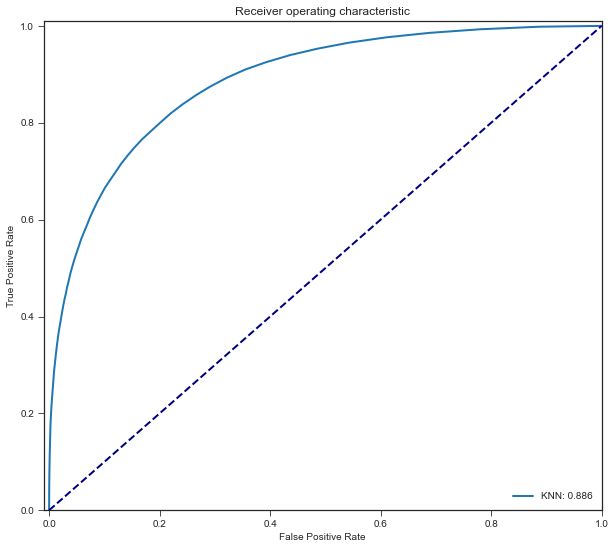

In [9]:
res2plot = []
true = (df[target]).astype(int).sort_index()
for result in [resultKNN]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))

from helpers import plotROCs
plotROCs(res2plot)

In [10]:
import pickle

# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("result_KNN.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(resultKNN, fp)